### Set up google drive for package development

1. Install nbdev and fastcore package
2. Mount your google drive
3. Change to package directory
4. Load the data


In [ ]:
# installing required packages
!pip install -U nbdev
!pip install fastcore -U # to deal with !nbdev_build_lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# installing fuzzywuzzy
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


%matplotlib inline

# Overview

In this project, we will build an `item-based collaborative filtering` system using [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/). 

We will train a KNN model to cluster similar movies based on users' ratings and make movie recommendations based on similarity scores of previously rated movies.

## Recommender Systems

**Introduction**

A [Recommender system](https://en.wikipedia.org/wiki/Recommender_system) is an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. 

**Types of Recommender Systems**

Recommender systems can be loosely broken down into three categories: `content based`, `collaborative filtering`, and `hybrid`.


- `Content-based recommenders` use the features of items to recommend other similar items. e.g., If I browse Nike soccer shoes on amazon.com, other shoes with similar features (color, type, price, etc.) would be shown on the webpage. I could also be shown similar sports items, e.g., soccer.

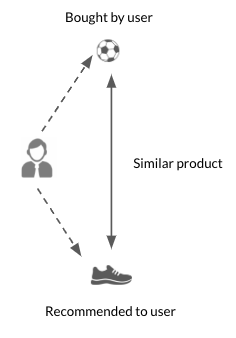

- `Collaborative filtering recommenders` use user-item interaction (matrix) to recommend items to a user.

**Types of Collaborative Filtering Recommender Systems**

Collaborative filtering can be either user-based or item-based:

  - `user-based collaborative filtering` recommends
  `items preferred by users that behave like target user`

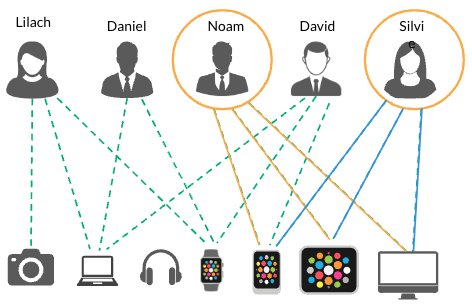

  - `item-based collaborative filtering` recommends `items similar to items preferred by target user`

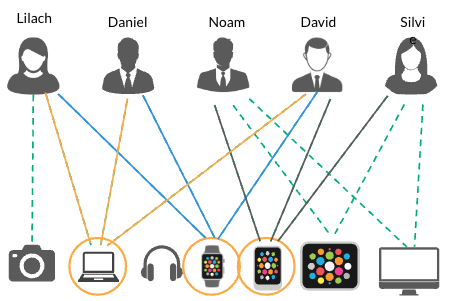

**User-based vs. Item-Based Collaborative Filtering**

> `item-based collaborative filtering` is preferred over `user-based collaborative filtering` because item-based can be computed offline, thus more scalable to a large dataset.

This is because user behavior changes more frequently and more drastically than item-based characteristics.

**Matrix Representation**

If item-user interactions are organized by items being rows and users being columns, we have `df_iu`:

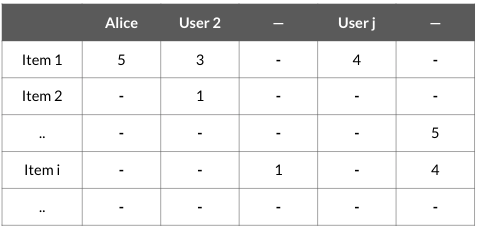

df_iu: an item-user interaction dataframe with 
- `row i` as item $i$ 
- `column j` as user $j$
- `entry` $(i,j)$ as rating of item $i$  by user $j$

> `df_iu` is a collection of m items; each item has n features which are the rating of each user to this item.

Similarly, if the item-user interactions are organized by users being rows and items being a column, we have `df_ui`. You can work out the details as shown in `df_iu`.

Reference: [Item-based Collaborative Filtering](https://beckernick.github.io/music_recommender/)


## Data Sets
We will use the `MovieLens Datasets`, which you can download [here](https://grouplens.org/datasets/movielens/latest/).

This dataset (ml-latest.zip) describes a 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995, and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least one movie. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.

## Project Content
1. Load data
2. Exploratory data analysis
3. Train the KNN model for item-based collaborative filtering
4. Use this trained model to make movie recommendations for me
5. Deep dive into the bottleneck of item-based collaborative filtering.
 - cold start problem
 - data sparsity problem
 - popularity bias (how to recommend products from the tail of product distribution)
 - scalability bottleneck
6. Further study

## 1. Load Data

Instead of using string values such as `'userId'`, `'movieId'` etc, in the notebook, we'll define a global variable at the start that will be set to these strings. 

This will help us switch around `user id` and `item id` easily and enhance the reusability of the code.

In [ ]:
u_id = 'userId'
i_id = 'movieId'
rating = 'rating'

In [ ]:
# load item data
df_i = pd.read_csv(
    'drive/MyDrive/amazing_recommender/movies.csv',
    usecols=[i_id, 'title'],
    dtype={i_id: 'int32', 'title': 'str'})

# load item-user interaction data
df_iu = pd.read_csv(
    'drive/MyDrive/amazing_recommender/ratings.csv',
    usecols=[u_id, i_id, rating],
    dtype={u_id: 'int32', i_id: 'int32', rating: 'float32'})

In [ ]:
df_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int32 
 1   title    9742 non-null   object
dtypes: int32(1), object(1)
memory usage: 114.3+ KB


In [ ]:
df_iu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB


In [ ]:
df_i.tail()

,movieId,title
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)
9741,193609,Andrew Dice Clay: Dice Rules (1991)


In [ ]:
df_iu.tail()

,userId,movieId,rating
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0
100835,610,170875,3.0


In [ ]:
num_users = len(df_iu.userId.unique())
num_items = len(df_iu.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this data set


## 2. Exploratory data analysis
 - Plot the counts of each rating
 - Plot rating frequency of each movie

#### 1. Plot the counts of each rating

We first need to get the counts of each rating from rating data

In [ ]:
# get count
df_iu_cnt_tmp = pd.DataFrame(df_iu.groupby(rating).size(), columns=['count'])
df_iu_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


**Zero Ratings:**

We'll use zero ratings in this dataset to represent a lack of rating for a given user-movie combination. This is how we are filling up none ratings here, and care must be taken not to use this approach for all recommender projects.

We can see that the above table does not include counts of zero rating scores.

So we need to add that in the rating count dataframe as well.

In [ ]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_iu.shape[0]
# append counts of zero rating to df_ratings_cnt
df_iu_cnt = df_iu_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_iu_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


The count for zero rating scores is too big to compare with others. So let's take log transform for count values, and then we can plot them to compare.

In [ ]:
# add log count
df_iu_cnt['log_count'] = np.log(df_iu_cnt['count'])
df_iu_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


Text(0, 0.5, 'number of ratings')

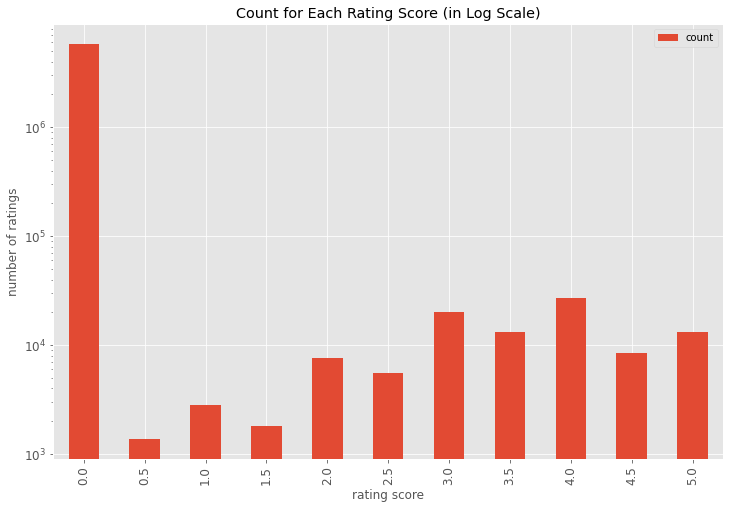

In [ ]:
ax = df_iu_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x=rating+' score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("rating score")
ax.set_ylabel("number of ratings")

Interestingly, more people give rating scores of 3 and 4 than others. 

#### 2. Plot rating frequency of all movies

In [ ]:
df_iu.sample(10)

,userId,movieId,rating
37586,254,1200,4.0
91247,591,260,5.0
42911,288,4587,2.0
1588,16,904,3.5
23532,160,2701,1.0
47957,310,2372,2.0
73500,474,1357,3.5
84801,550,116797,4.5
20405,135,1198,4.0
84598,543,89904,0.5


In [ ]:
# get rating frequency
df_i_cnt = pd.DataFrame(df_iu.groupby(i_id).size(), columns=['count'])
df_i_cnt.sample(20)

,count
movieId,
50802,3
170827,1
321,2
53450,1
2706,103
1201,72
51088,2
167370,2
5304,2


Text(0, 0.5, 'number of ratings')

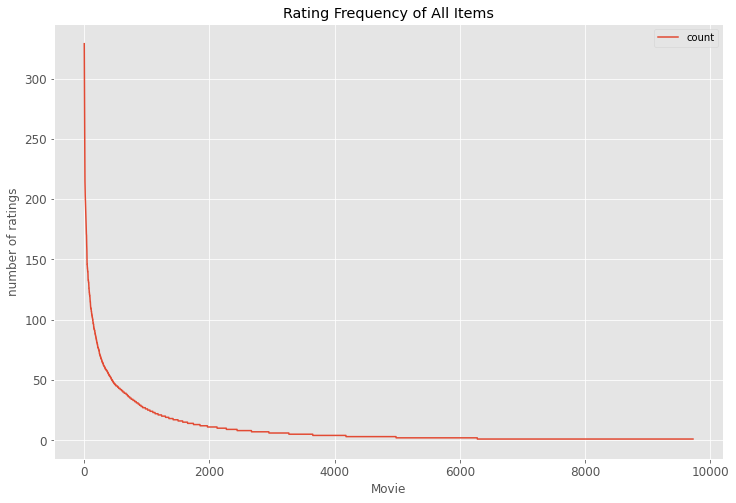

In [ ]:
# plot rating frequency of all movies
ax = df_i_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Items',
        fontsize=12
    )
ax.set_xlabel("Movie")
ax.set_ylabel("number of ratings")

The rating distribution among movies often satisfies a `long-tail` property, which is very common in real-world datasets. 

According to this property, only a tiny
fraction of the items are rated frequently. Such items are referred to as popular items. The
vast majority of items are rated rarely. This results in a highly skewed distribution of the
underlying ratings.

Let's plot the same distribution but with a log scale

Text(0, 0.5, 'number of ratings (log scale)')

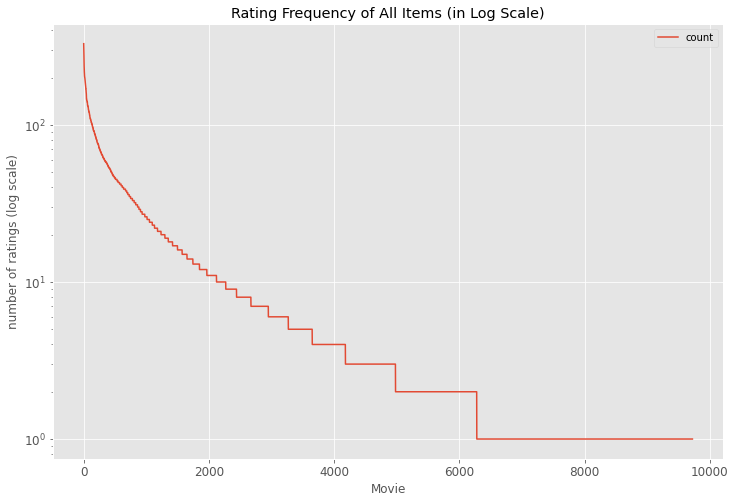

In [ ]:
# plot rating frequency of all movies in log scale
ax = df_i_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Items (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel('Movie')
ax.set_ylabel("number of ratings (log scale)")

We can see that roughly 10,000 out of 53,889 movies are rated more than 100 times. More interestingly, roughly 20,000 out of 53,889 movies are rated less than only ten times. Let's look closer by displaying the top quantiles of rating counts.

In [ ]:
df_i_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

So about 1% of movies have roughly 97,999 ratings, 5% have 1,855 or more, and 20% have 100 or more. Since we have so many movies, we'll limit it to the top 25%. This is an arbitrary threshold for popularity, but it gives us about 13,500 different movies. We still have a pretty good amount of movies for modeling.

There are two reasons why we want to **filter to roughly 13,500 movies** in our dataset.
 - **Memory issue:** we don't want to run into the "MemoryError" during model training
 - **Improve KNN performance:** lesser known movies have ratings from fewer viewers, making the pattern noisier. Dropping out less known movies can improve recommendation quality

In [ ]:
# filter data
popularity_thres = 50
popular_i = list(set(df_i_cnt.query('count >= @popularity_thres').index))
df_iu_drop_i = df_iu[df_iu[i_id].isin(popular_i)]
print('shape of original ratings data: ', df_iu.shape)
print('shape of ratings data after dropping unpopular items: ', df_iu_drop_i.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular items:  (41360, 3)


After dropping 75% of movies in our dataset, we still have a huge dataset. So next, we can filter users to reduce the data size further.

In [ ]:
# get number of ratings given by every user
df_u_cnt = pd.DataFrame(df_iu_drop_i.groupby(u_id).size(), columns=['count'])
df_u_cnt.tail()

,count
userId,
606,238
607,100
608,309
609,24
610,240


Text(0, 0.5, 'number of ratings')

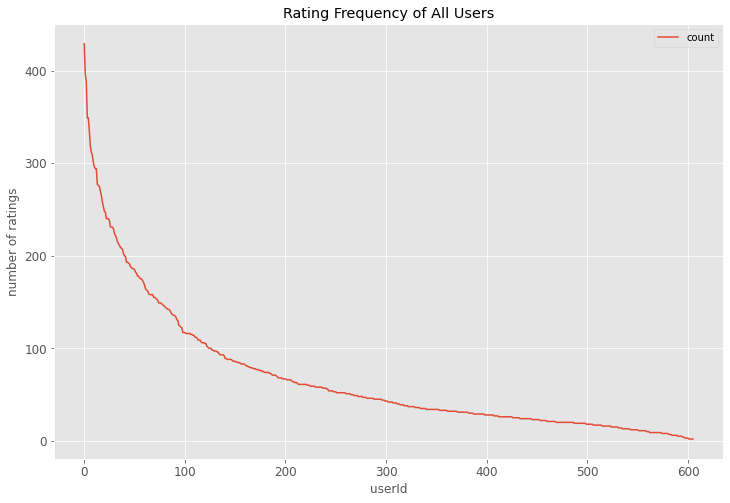

In [ ]:
# plot rating frequency of all users
ax = df_u_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel(u_id)
ax.set_ylabel("number of ratings")

In [ ]:
df_u_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
0.60     56.00
0.55     48.00
Name: count, dtype: float64

We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail properties. Only a tiny fraction of users are actively engaged with rating movies they watched. The vast majority of users aren't interested in rating movies. So we can limit users to the top 40%, about 113,291 users.

In [ ]:
# filter data
ratings_thres = 50
active_users = list(set(df_u_cnt.query('count >= @ratings_thres').index))
df_iu_drop_u = df_iu_drop_i[df_iu_drop_i[u_id].isin(active_users)]
print('shape of original ratings data: ', df_iu.shape)
print('shape of ratings data after dropping both unpopular items and inactive users: ', df_iu_drop_u.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular items and inactive users:  (32999, 3)


## 3. Train KNN model for item-based collaborative filtering
 - Reshaping the Data
 - Fitting the Model

#### 1. Reshaping the Data
For K-Nearest Neighbors, we want the data to be in an (item, user) matrix, where each row is an item(movie), and each column is a different user. 

1. To reshape the dataframe, we'll pivot the dataframe to the wide format with movies as rows and users as columns. 

1. Then, we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). 

1. Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [ ]:
# 1 & 2: pivot and create movie-user matrix
iu_mat = df_iu_drop_u.pivot(index=i_id, columns=u_id, values=rating).fillna(0)

# create mapper from item (movie) title to index
item_to_idx = {
    item: i for i, item in 
    enumerate(list(df_i.set_index(i_id).loc[iu_mat.index].title))
}

# 3. transform matrix to scipy sparse matrix
iu_mat_sparse = csr_matrix(iu_mat.values)

#### 2. Fitting the Model
Time to implement the model. We'll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity between artist vectors by using cosine similarity.

In [ ]:
#%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(iu_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

## 4. Use this trained model to make item recommendations
And we're finally ready to make some recommendations!

In [ ]:
def fuzzy_matching(mapper:dict, fav_item:str, verbose:bool=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Args
    ----    
    mapper: dict, map movie title name to index of the movie in data

    fav_item: str, e.g. name of user input movie
    
    verbose: bool, print log if True

    Returns
    -------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_item.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper:dict, fav_item:str, n_recommendations:int):
    """
    return top n similar movie recommendations based on user's input movie


    Args
    ----
    model_knn: sklearn model, knn model

    data: item-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Returns
    -------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input item:', fav_item)
    idx = fuzzy_matching(mapper, fav_item, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_item))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite = 'It is a wonderful life'

make_recommendation(
    model_knn=model_knn,
    data=iu_mat_sparse,
    fav_item=my_favorite,
    mapper=item_to_idx,
    n_recommendations=10)

You have input item: It is a wonderful life
Found possible matches in our database: ["It's a Wonderful Life (1946)"]

Recommendation system start to make inference
......

Recommendations for It is a wonderful life:
1: Godfather: Part II, The (1974), with distance of 0.5093856453895569
2: Rain Man (1988), with distance of 0.5049393177032471
3: Some Like It Hot (1959), with distance of 0.5019153356552124
4: Rear Window (1954), with distance of 0.5014127492904663
5: When Harry Met Sally... (1989), with distance of 0.4962582588195801
6: Mary Poppins (1964), with distance of 0.49083685874938965
7: Wizard of Oz, The (1939), with distance of 0.4602513909339905
8: Graduate, The (1967), with distance of 0.4559705853462219
9: Monty Python and the Holy Grail (1975), with distance of 0.4353857636451721
10: Casablanca (1942), with distance of 0.4322146773338318


Takeaways:

*   **Release Years of Recommended Movies:** It is very interesting that my **KNN** model recommends movies that were also produced in very similar years.
*   **Cosine Distances:** However, all those recommendations' cosine distance is relatively small. 
*   **Data Sparsity:** This is because there are too many zero values in our movie-user matrix. With too many zero values in our data, the data sparsity becomes a real issue for **KNN** model, and the distance in **KNN** model starts to fall apart.

So I'd like to dig deeper and look closer at our data.

#### (extra inspection) 
Let's now look at how sparse the movie-user matrix is by calculating the percentage of zero values in the data.

In [ ]:
# calcuate total number of entries in the movie-user matrix
num_entries = iu_mat.shape[0] * iu_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (iu_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 72.64% of ratings in our data is missing


This result confirms my hypothesis. The vast majority of entries in our data are zero.

This explains the considerable distance between both similar and opposite items.


## 5. The bottleneck of item-based collaborative filtering using KNN.
 - Cold start problem
 - Data sparsity problem
 - Popularity bias (how to recommend products from the tail of product distribution)
 - Scalability bottleneck

**Cold Start Problem**

We saw there is 98.35% of user-item interactions are not yet recorded, even after I filtered out less-known item and inactive users. Apparently, we don't even have sufficient information for the system to make reliable inferences for users or items. This is called **Cold Start** problem in recommender system.

There are three cases of cold start:

1. New community: refers to the start-up of the recommender, when, although a catalogue of items might exist, almost no users are present and the lack of user-item interaction makes very hard to provide reliable recommendations, called `iu-cold-start` problem

2. New item: a new item is added to the system, it might have some content information but no interactions are present, called `item-cold-start` problem

3. New user: a new user registers and has not provided any interaction yet, therefore it is not possible to provide personalized recommendations, called `user-cold-start` problem

**Item Cold Start Problem [Data Sparsity]**

We are not concerned with the `user-cold-start` problem because we can use item-based filtering to make recommendations for new user. In our case, we are more concerned with the first two cases (`iu-cold-start`, `item-cold-start`) especially the second case.

The `item cold-start` problem refers to when items added to the catalogue have either none or very few interactions. This constitutes a problem mainly for collaborative filtering algorithms due to the fact that they rely on the user-item interactions to make recommendations. If no interactions are available then a pure collaborative algorithm cannot recommend the item. In case only a few interactions are available, although a collaborative algorithm will be able to recommend it, the quality of those recommendations will be poor. 

**Popularity Bias**

We often face a similar issue when it comes to `unpopular items`. In some cases (e.g. movie recommendations) it might happen that a handful of items receive an extremely high number of iteractions, while most of the items only receive a fraction of them. This is also referred to as a `popularity bias`. Please recall the previously mentioned long-tail skewed distribution for movie rating frequency.

**Scalability**

In addition to that, `scalability` is also a big issue in the KNN model. Its time complexity is O(nd + kn), where n is the training set's cardinality, and d is each sample's dimension. And KNN takes more time to make inferences than training, which increases the prediction latency.

## 6. Further study

Use spark's ALS to solve above problems